# Obtaining the file (song)

Shiva the Destroyer · Peter Matthew Bauer

Liberation!

℗ 2014 Fortune Tellers Music

Released on: 2014-06-24

Composer, Writer: Peter Matthew Bauer

I do NOT own this song.

In [1]:
from extract import download_audio, convert
from dotenv import load_dotenv
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import noisereduce as nr


c:\Users\marqu\anaconda3\envs\lyricsenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load environment variables from .env file
load_dotenv()

# Access the environment variable
executionPath = os.getenv('FFMPEG_PATH')


In [3]:
# we first download the video and then extract the audio
download_audio("https://www.youtube.com/watch?v=4HMknVoDFAQ", savePath= "./audios/shivaTheDestroyer")

[youtube] Extracting URL: https://www.youtube.com/watch?v=4HMknVoDFAQ
[youtube] 4HMknVoDFAQ: Downloading webpage
[youtube] 4HMknVoDFAQ: Downloading ios player API JSON
[youtube] 4HMknVoDFAQ: Downloading mweb player API JSON
[youtube] 4HMknVoDFAQ: Downloading m3u8 information
[info] 4HMknVoDFAQ: Downloading 1 format(s): 251
[download] Destination: audios\shivaTheDestroyer
[download] 100% of    3.71MiB in 00:00:00 at 7.49MiB/s   
[ExtractAudio] Destination: audios\shivaTheDestroyer.mp3
Deleting original file audios\shivaTheDestroyer (pass -k to keep)


# Voice Isolation

I now aim to isolate the voice for a clearer voice.

In [6]:
# load data
filename = './audios/shivaTheDestroyer.wav'
y, sr = librosa.load(filename, sr = None)

In [9]:
# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))

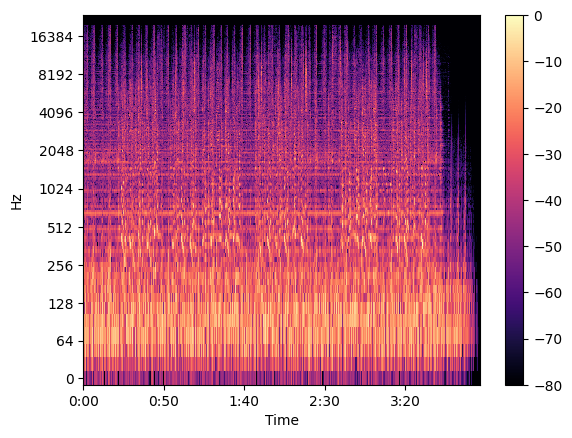

In [11]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The "wiggly lines" visible in the upper part of the spectrogram correspond to the vocal components of the audio. These lines indicate harmonic structures, which are characteristic of human voices. They show how the pitch (fundamental frequency) and its overtones vary over time.
The instrumentation (e.g., drums, bass, or background music) typically occupies the lower frequency bands (the denser, horizontal bands near the bottom of the spectrogram).

In [12]:
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [13]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

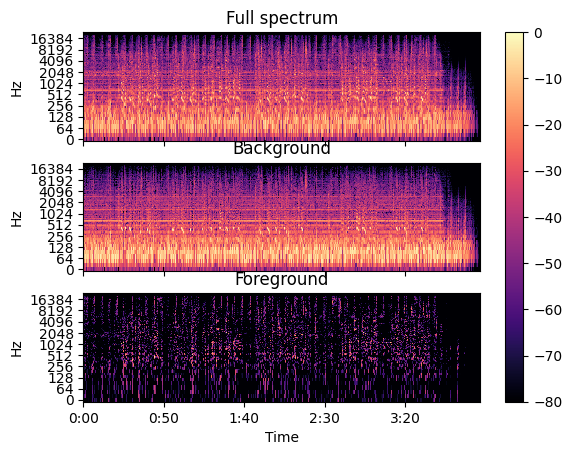

In [14]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

- background: This spectrogram represents the background or accompaniment in the audio signal.
- foreground: This spectrogram represents the foreground, primarily containing dynamic and prominent features like vocals or lead instruments.

In [15]:
y_foreground = librosa.istft(S_foreground * phase)

In [7]:
# source separation
harmonic, percussive = librosa.effects.hpss(y)

In [17]:
sf.write('./audios/vocals.wav', y_foreground, sr)

# Noise reduction

In [18]:
rate, data = wavfile.read('./audios/vocals.wav') # read the data

In [20]:
reduced_noise = nr.reduce_noise(y = data, sr = rate)

In [ ]:
wavfile.write("./audios/vocals_noise_reduced.wav", rate, reduced_noise)

# Convert from `.wav` to `.mp3`

Since the input file for Whisper should be in `.mp3` format.

In [4]:
convert(exec_path= executionPath,
        wav_file=  "./audios/vocals_noise_reduced.wav",
        mp3_file=  "./audios/vocals_noise_reduced.mp3")